In [1]:
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib  # For saving the model
import warnings

warnings.filterwarnings('ignore')

# Set plot style
sns.set_style("whitegrid")
print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [3]:
def load_and_clean_data(file_path):
    print(f"Loading data from: {file_path}")
    df = pd.read_csv(file_path)

    # 1. Create a datetime column to sort the data properly
    # The columns are likely 'year', 'month', 'day', 'hour'
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

    # 2. Sort by datetime (CRITICAL for lag features later)
    df = df.sort_values('datetime').reset_index(drop=True)

    print(f"Data shape: {df.shape}")
    print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")

    return df

# Replace this with your actual file path (e.g., 'site_1_train_data.csv')
# df = load_and_clean_data('site_1_train_data.csv')

In [4]:
def engineer_features(df):
    df_eng = df.copy()

    # --- 1. Meteorological Interactions ---
    # Calculate Wind Speed magnitude from U and V components
    # Formula: sqrt(u^2 + v^2)
    df_eng['wind_speed'] = np.sqrt(df_eng['u_forecast']**2 + df_eng['v_forecast']**2)

    # --- 2. Temporal Cyclical Features ---
    # Convert 'hour' and 'month' into circles (sin/cos)
    df_eng['hour_sin'] = np.sin(2 * np.pi * df_eng['hour'] / 24)
    df_eng['hour_cos'] = np.cos(2 * np.pi * df_eng['hour'] / 24)
    df_eng['month_sin'] = np.sin(2 * np.pi * df_eng['month'] / 12)
    df_eng['month_cos'] = np.cos(2 * np.pi * df_eng['month'] / 12)

    # --- 3. Satellite Data Handling ---
    # The readme says satellite data is daily. We forward-fill it just in case,
    # though the provided dataset likely repeats it for every hour of the day.
    satellite_cols = ['NO2_satellite', 'HCHO_satellite', 'ratio_satellite']
    for col in satellite_cols:
        if col in df_eng.columns:
            # If missing (NaN), assume previous day's value holds (forward fill)
            df_eng[col] = df_eng[col].ffill().bfill()

    # Drop the original 'datetime' as models can't digest it raw
    # We keep 'year', 'month', 'day' if you want, but cyclical is better.
    # We drop 'datetime' before training.
    return df_eng

# Apply the engineering
# df_processed = engineer_features(df)

In [5]:
def train_model(df, target_col):
    print(f"\n🚀 Training model for target: {target_col}")

    # 1. Define Features (X) and Target (y)
    # Drop targets and non-numeric columns
    drop_cols = ['O3_target', 'NO2_target', 'datetime']
    X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
    y = df[target_col]

    # 2. Split Data
    # Since it's time-series, we technically shouldn't shuffle,
    # but the Read_me suggests random 75/25 split is acceptable.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3. Initialize XGBoost
    # n_estimators=1000 with early_stopping prevents overfitting
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,          # Lower than 20 to prevent overfitting
        subsample=0.8,        # Use 80% of data per tree (adds randomness)
        colsample_bytree=0.8, # Use 80% of features per tree
        n_jobs=-1,
        random_state=42
    )

    # 4. Train
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=100  # Print progress every 100 trees
    )

    # 5. Evaluate
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    print(f"✅ {target_col} Results:")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R² Score: {r2:.4f}")

    return model, X_test.columns.tolist()

# Usage:
# model_o3, features = train_model(df_processed, 'O3_target')
# model_no2, features = train_model(df_processed, 'NO2_target')

In [6]:
# --- STEP 5: ROBUST TRAINING ON ALL 7 SITES ---

def train_on_all_sites():
    all_data = []

    # 1. Hardcoded Site Metadata (Derived from your file)
    # Format: Site ID -> {'lat': Latitude, 'lon': Longitude}
    site_coords = {
        1: {'lat': 28.69536, 'lon': 77.18168}, # Ashok Vihar
        2: {'lat': 28.57180, 'lon': 77.07125}, # Indragandhi airport
        3: {'lat': 28.58278, 'lon': 77.23441}, # Javaharlal Stadium
        4: {'lat': 28.82286, 'lon': 77.10197}, # DSIDC Industrial Area
        5: {'lat': 28.53077, 'lon': 77.27123}, # Delhi Institute of tool Engineering
        6: {'lat': 28.72954, 'lon': 77.09601}, # Rohini, Delhi
        7: {'lat': 28.71052, 'lon': 77.24951}  # Rajiv Nagar
    }

    print("🔄 Starting Data Merge Process...")

    # 2. Loop through Sites 1 to 7
    for site_id, coords in site_coords.items():
        filename = f'/content/site_{site_id}_train_data.csv'
        try:
            # A. Load the individual site data
            df_site = load_and_clean_data(filename)

            # B. Feature Engineering (Must be done PER SITE to preserve time order)
            df_site = engineer_features(df_site)

            # C. Add Location Features
            df_site['latitude'] = coords['lat']
            df_site['longitude'] = coords['lon']
            df_site['site_id'] = site_id  # Helpful for the model to learn specific site bias

            all_data.append(df_site)
            print(f"   ✅ Merged Site {site_id} ({len(df_site)} rows)")

        except FileNotFoundError:
            print(f"   ⚠️ Warning: {filename} not found. Skipping.")

    # 3. Combine into one Master DataFrame
    if not all_data:
        print("❌ No data loaded! Check if your CSV files are in the correct folder.")
        return

    master_df = pd.concat(all_data, ignore_index=True)
    print(f"\n📊 Final Combined Dataset Shape: {master_df.shape}")

    # 4. Train O3 Model
    print("\n🦾 Training Unified O3 Model (All Sites)...")
    model_o3, feature_names = train_model(master_df, 'O3_target')

    # 5. Train NO2 Model
    print("\n🦾 Training Unified NO2 Model (All Sites)...")
    model_no2, _ = train_model(master_df, 'NO2_target')

    # 6. Save Models
    joblib.dump(model_o3, 'model_o3_combined.pkl')
    joblib.dump(model_no2, 'model_no2_combined.pkl')
    # We save the feature list to ensure we feed columns in the exact same order during the app
    joblib.dump(feature_names, 'model_features.pkl')

    print("\n🚀 SUCCESS! Models saved as 'model_o3_combined.pkl' and 'model_no2_combined.pkl'")
    print("These are the files we will deploy to the cloud.")

# --- RUN IT ---
train_on_all_sites()

🔄 Starting Data Merge Process...
Loading data from: /content/site_1_train_data.csv
Data shape: (25081, 17)
Date range: 2019-07-14 00:00:00 to 2024-06-30 00:00:00
   ✅ Merged Site 1 (25081 rows)
Loading data from: /content/site_2_train_data.csv
Data shape: (25969, 17)
Date range: 2019-07-10 00:00:00 to 2024-06-30 00:00:00
   ✅ Merged Site 2 (25969 rows)
Loading data from: /content/site_3_train_data.csv
Data shape: (21913, 17)
Date range: 2019-07-13 00:00:00 to 2024-06-30 00:00:00
   ✅ Merged Site 3 (21913 rows)
Loading data from: /content/site_4_train_data.csv
Data shape: (24505, 17)
Date range: 2019-07-11 00:00:00 to 2024-06-30 00:00:00
   ✅ Merged Site 4 (24505 rows)
Loading data from: /content/site_5_train_data.csv
Data shape: (25081, 17)
Date range: 2019-07-10 00:00:00 to 2024-06-30 00:00:00
   ✅ Merged Site 5 (25081 rows)
Loading data from: /content/site_6_train_data.csv
Data shape: (26353, 17)
Date range: 2019-07-10 00:00:00 to 2024-06-30 00:00:00
   ✅ Merged Site 6 (26353 rows)
L

🔄 Loading saved models...
✅ Models loaded!
🔄 Loading data to generate comparison charts...

📊 Generating O3 Charts...


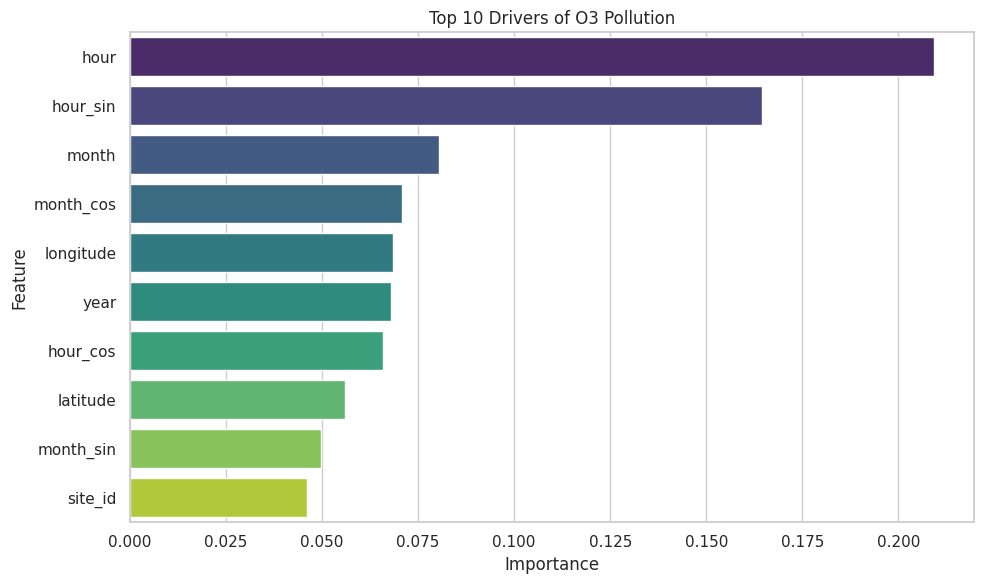

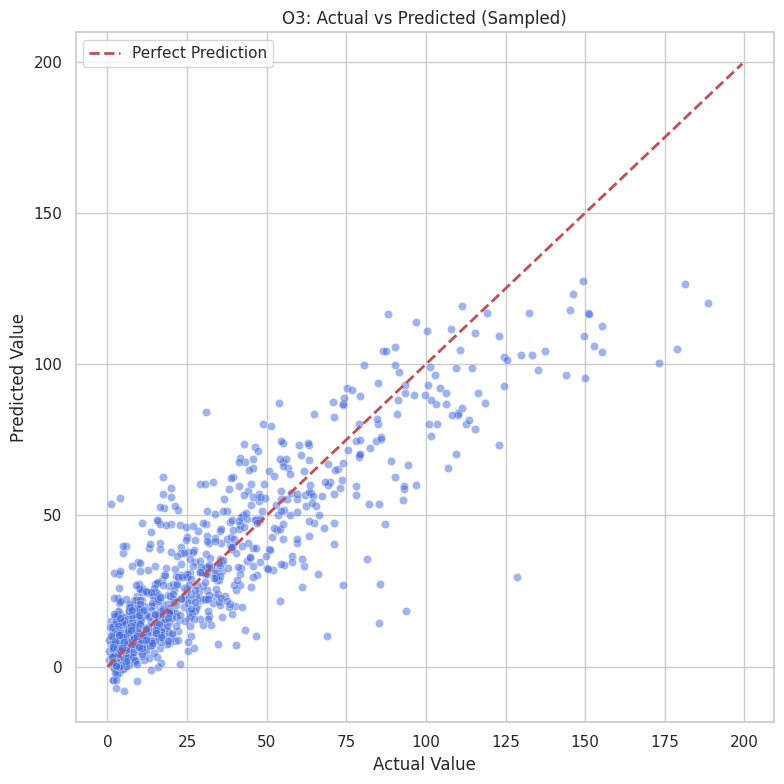

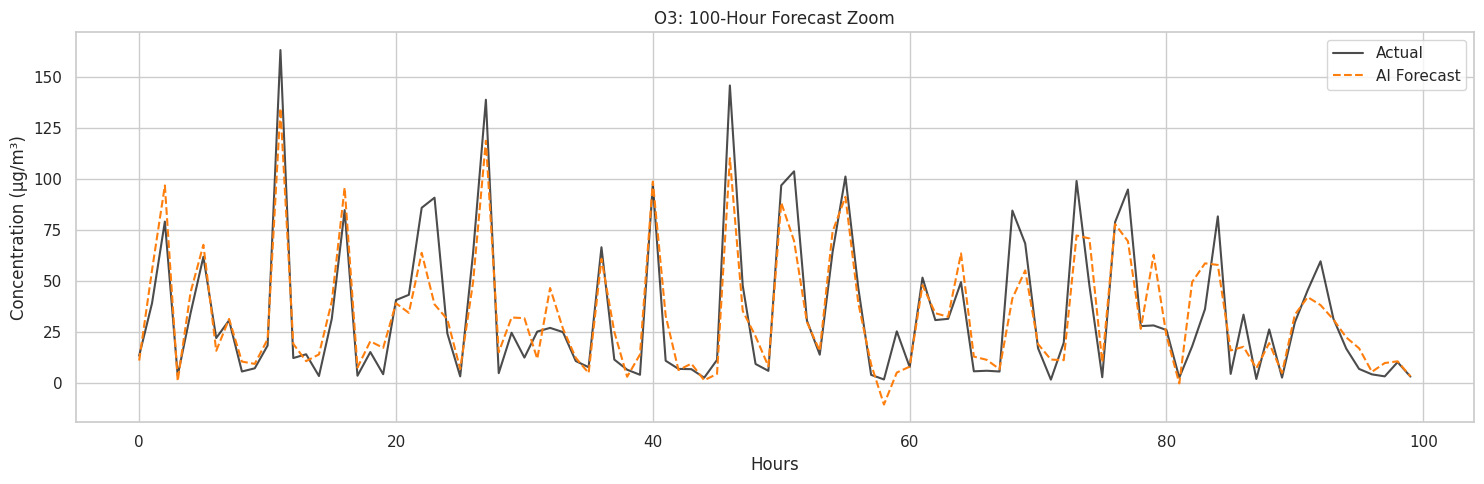


📊 Generating NO2 Charts...


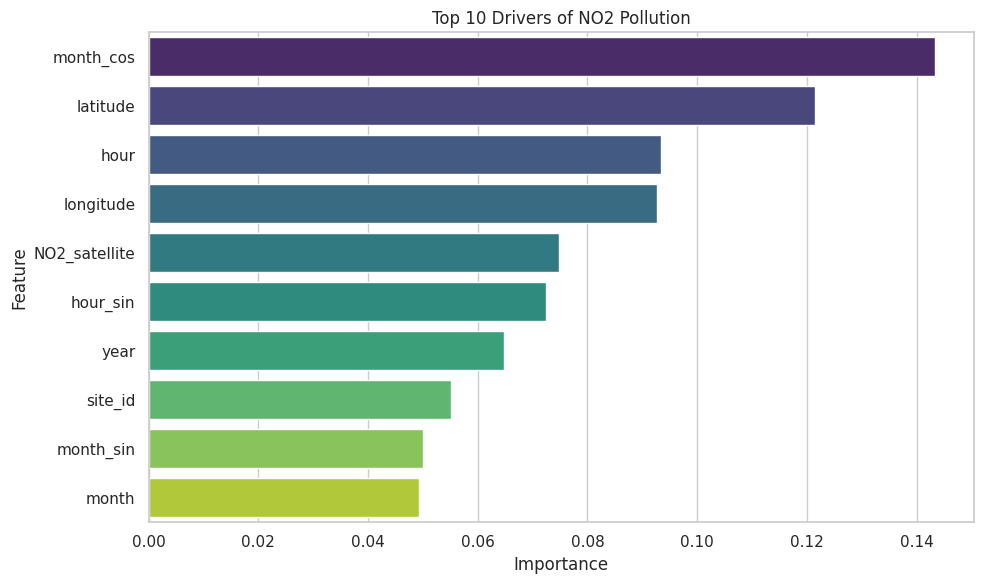

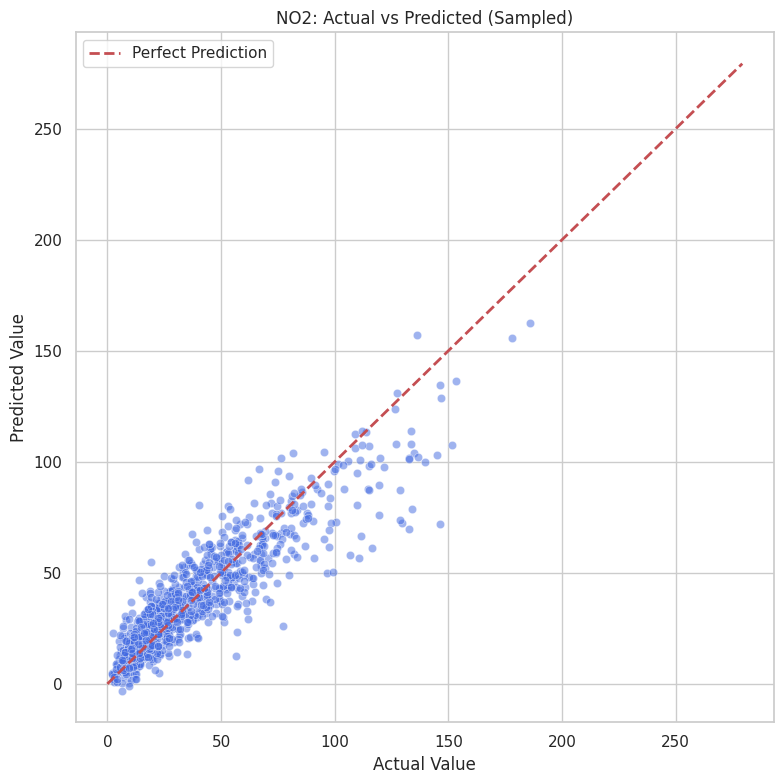

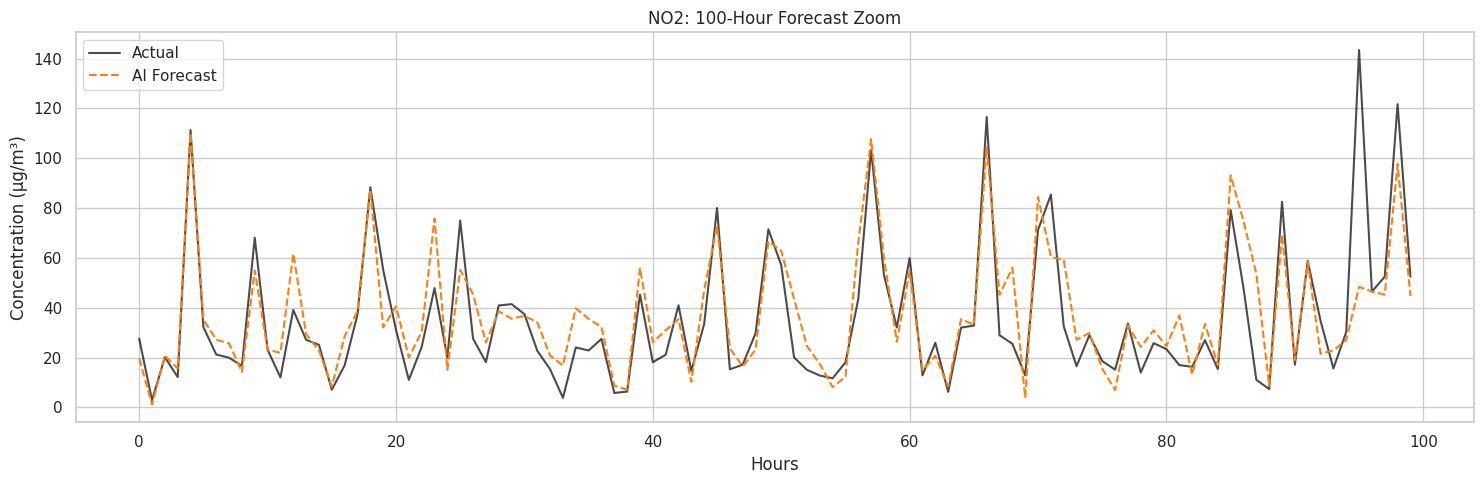


✨ Done! Check the output above or the 'plots' folder.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import os

# Create a folder for plots
if not os.path.exists('plots'):
    os.makedirs('plots')

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- 1. RE-DEFINE UTILS (Needed to process data for plotting) ---
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    df = df.sort_values('datetime').reset_index(drop=True)
    return df

def engineer_features(df):
    df_eng = df.copy()
    # Physics features
    df_eng['wind_speed'] = np.sqrt(df_eng['u_forecast']**2 + df_eng['v_forecast']**2)
    # Cyclical features
    df_eng['hour_sin'] = np.sin(2 * np.pi * df_eng['hour'] / 24)
    df_eng['hour_cos'] = np.cos(2 * np.pi * df_eng['hour'] / 24)
    df_eng['month_sin'] = np.sin(2 * np.pi * df_eng['month'] / 12)
    df_eng['month_cos'] = np.cos(2 * np.pi * df_eng['month'] / 12)
    # Impute
    for col in ['NO2_satellite', 'HCHO_satellite', 'ratio_satellite']:
        if col in df_eng.columns:
            df_eng[col] = df_eng[col].ffill().bfill()
    return df_eng

# --- 2. PLOTTING FUNCTIONS ---

def plot_feature_importance(model, feature_names, target_name):
    importance = model.feature_importances_
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    imp_df = imp_df.sort_values(by='Importance', ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=imp_df, palette='viridis')
    plt.title(f'Top 10 Drivers of {target_name} Pollution')
    plt.tight_layout()
    plt.savefig(f'plots/{target_name}_importance.png')
    plt.show()

def plot_scatter(y_true, y_pred, target_name):
    plt.figure(figsize=(8, 8))
    # Sample 1000 points to avoid overcrowding the plot
    indices = np.random.choice(len(y_true), size=min(1000, len(y_true)), replace=False)

    sns.scatterplot(x=y_true.iloc[indices], y=y_pred[indices], alpha=0.5, color='royalblue')

    # Perfect prediction line
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')

    plt.title(f'{target_name}: Actual vs Predicted (Sampled)')
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/{target_name}_scatter.png')
    plt.show()

def plot_timeline(y_true, y_pred, target_name):
    # Plot just the first 100 hours of the test set to see the detail
    plt.figure(figsize=(15, 5))
    plt.plot(range(100), y_true[:100], label='Actual', color='black', alpha=0.7)
    plt.plot(range(100), y_pred[:100], label='AI Forecast', color='#ff7f0e', linestyle='--')

    plt.title(f'{target_name}: 100-Hour Forecast Zoom')
    plt.xlabel('Hours')
    plt.ylabel('Concentration (µg/m³)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/{target_name}_timeline.png')
    plt.show()

# --- 3. MAIN EXECUTION ---

def generate_charts():
    print("🔄 Loading saved models...")
    try:
        model_o3 = joblib.load('model_o3_combined.pkl')
        model_no2 = joblib.load('model_no2_combined.pkl')
        print("✅ Models loaded!")
    except Exception as e:
        print(f"❌ Error loading models: {e}")
        return

    # Combine data from all 7 sites again (just to get X_test and y_test)
    all_data = []
    site_coords = {
        1: {'lat': 28.69536, 'lon': 77.18168}, 2: {'lat': 28.57180, 'lon': 77.07125},
        3: {'lat': 28.58278, 'lon': 77.23441}, 4: {'lat': 28.82286, 'lon': 77.10197},
        5: {'lat': 28.53077, 'lon': 77.27123}, 6: {'lat': 28.72954, 'lon': 77.09601},
        7: {'lat': 28.71052, 'lon': 77.24951}
    }

    print("🔄 Loading data to generate comparison charts...")
    for site_id, coords in site_coords.items():
        # Note: Adjust path if your csvs are in a subfolder
        filename = f'site_{site_id}_train_data.csv'
        if os.path.exists(filename):
            df = load_and_clean_data(filename)
            df = engineer_features(df)
            df['latitude'] = coords['lat']
            df['longitude'] = coords['lon']
            df['site_id'] = site_id
            all_data.append(df)

    if not all_data:
        print("❌ No CSV data found to plot against!")
        return

    master_df = pd.concat(all_data, ignore_index=True)

    # Prepare Features
    drop_cols = ['O3_target', 'NO2_target', 'datetime']
    features = [c for c in master_df.columns if c not in drop_cols]
    X = master_df[features]

    # --- PLOT FOR O3 ---
    print("\n📊 Generating O3 Charts...")
    y_o3 = master_df['O3_target']
    # Use same seed as training to ensure we look at the same "Test" data
    _, X_test, _, y_test = train_test_split(X, y_o3, test_size=0.2, random_state=42)

    preds_o3 = model_o3.predict(X_test)

    plot_feature_importance(model_o3, features, 'O3')
    plot_scatter(y_test, preds_o3, 'O3')
    plot_timeline(y_test.reset_index(drop=True), preds_o3, 'O3')

    # --- PLOT FOR NO2 ---
    print("\n📊 Generating NO2 Charts...")
    y_no2 = master_df['NO2_target']
    _, X_test, _, y_test = train_test_split(X, y_no2, test_size=0.2, random_state=42)

    preds_no2 = model_no2.predict(X_test)

    plot_feature_importance(model_no2, features, 'NO2')
    plot_scatter(y_test, preds_no2, 'NO2')
    plot_timeline(y_test.reset_index(drop=True), preds_no2, 'NO2')

    print("\n✨ Done! Check the output above or the 'plots' folder.")

# Run it
generate_charts()